## Data Assimilation Workflow

1. Get ignition, ignite_timestamp
2. Get observation, observe_timestamp
3. Choose weather station and obtain windspeed/winddirection
4. Get model: Use ignition and wind at ignition timestamp to run a simulation.
5. Get nextobservation, nextobserve_timestamp
6. Get modifiedignition: Feed ignition, observation, weather, model and nextobservation into Kalman Filter
7. Get nextmodel: Use modifiedmodel as the next ignition

In [34]:
from shapely.geometry import MultiPolygon, Polygon

import pandas as pd
import geopandas as gpd
import numpy as np

import datetime

from matplotlib import pyplot as plt

import requests
import arrow
import uuid

import sys
sys.path.append('/home/jovyan/python-helper/src/')

from loggers import TimeEstimator
from branca.colormap import LinearColormap

from matplotlib.colors import LinearSegmentedColormap

import farsiteutils_v2 as futils
from kalmanutils import interpolate_perimeter, get_vertices, calculate_vectors, align_perimeters, calculate_uncertainties_observed, calculate_modified, calculate_parameters

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_perimeter(vertices, ax, **kwargs):
    ax.plot(np.array(vertices)[:,0], 
            np.array(vertices)[:,1], **kwargs)

In [3]:
fp = futils.FilePaths('/home/jovyan/data/')
usr = futils.User(fp)

usr.db.gdfignitionAll = usr.db.gdfignitionAll.to_crs(epsg=5070)

Database interaction not yet implemented. Use pickle file for dataframes instead!


### Choose ignition

In [4]:
igniteidx = 'f23196b034474744bdca7df94b13e0f7'
compareidx = '9f82e870591748a9a8a01346d174f2a1'
lcpidx = '43b7f5db36994599861eec4849cc68fd'
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'

ignite_geom = usr.db.gdfignitionAll.loc[igniteidx, 'geometry']

ignition = get_vertices(ignite_geom)

### Choose input parameters for simulation

In [5]:
wind_speed = 16
wind_direction = 90

inputData = {'description': 'Maria2019',
             'igniteidx'  : igniteidx,
             'compareidx' : compareidx,
             'lcpidx'     : lcpidx,
             'barrieridx' : barrieridx,

             'windspeed': wind_speed, 'winddirection': wind_direction,
             'relhumid': 90, 'temperature': 20}

# Setup the mainapi for this calculation
mainapi = usr.calculatePerimeters(inputData)

{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


In [6]:
mainapi.run_farsite()

Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20221014/Run_00001/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20221014/Run_00001/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


### Obtain model output

In [7]:
model_geom = usr.db.gdfsimulation.iloc[-1]['geometry'].geoms[0]
model = get_vertices(model_geom)

### Collect observation

In [8]:
observe_geom = usr.db.gdfignitionAll.loc[compareidx, 'geometry']
observe = get_vertices(observe_geom)

In [9]:
# Calculate dt from observation and ignition
dt = int((usr.db.gdfignitionAll.loc[compareidx, 'datetime'] - usr.db.gdfignitionAll.loc[igniteidx, 'datetime']).total_seconds()/60)

### Rearrange the parameters to align, calculate velocities

In [15]:
ignition_aligned, model_velocity_aligned, model_aligned, observe_aligned, observed_velocity_aligned, ignition_uncertainties = calculate_parameters(ignition, observe, model, wind_direction, dt)

### Calculate Kalman parameters

In [28]:
# State transition matrix
F = np.eye(4*len(ignition_aligned))
for i in range(len(F)):
    if i%2 == 0:
        F[i,i+1] = dt

# State Vector
X = np.zeros((4*len(ignition_aligned), 1))
# Observation
Z = np.zeros((4*len(observe_aligned), 1))
Xpre = np.zeros((4*len(ignition_aligned), 1))
# Observed uncertainty
R = np.zeros_like(F)
# Covariance matrix
P = np.zeros_like(F)
# Measurement matrix
H = np.eye(len(X))
for i in range(len(ignition_aligned)):
    X[4*i] = ignition_aligned[i,0]
    X[4*i + 1] = model_velocity_aligned[i,0]
    X[4*i + 2] = ignition_aligned[i,1]
    X[4*i + 3] = model_velocity_aligned[i,1]
    
    Xpre[4*i] = model_aligned[i,0]
    Xpre[4*i + 1] = model_velocity_aligned[i,0]
    Xpre[4*i + 2] = model_aligned[i,1]
    Xpre[4*i + 3] = model_velocity_aligned[i,1]
    
    Z[4*i] = observe_aligned[i,0]
    Z[4*i + 1] = observed_velocity_aligned[i,0]
    Z[4*i + 2] = observe_aligned[i,1]
    Z[4*i + 3] = observed_velocity_aligned[i,1]
        
    R[[4*i, 4*i+1, 4*i+2, 4*i+3], [4*i, 4*i+1, 4*i+2, 4*i+3]] = ignition_uncertainties[i]
    P[[4*i, 4*i+1, 4*i+2, 4*i+3], [4*i, 4*i+1, 4*i+2, 4*i+3]] = 0.1

In [29]:
kf = KalmanFilter(len(X), len(Z))
kf.F = F
kf.R = R
kf.Q = 0
kf.P = P
kf.x = X
kf.H = H

In [30]:
%%time
kf.update(Z)

CPU times: user 1min 28s, sys: 11.9 s, total: 1min 40s
Wall time: 1min 39s


In [31]:
Xmodified = kf.x.copy()

In [55]:
xmod, vxmod, ymod, vymod = Xmodified[::4], Xmodified[1::4], Xmodified[2::4], Xmodified[3::4]
modified_vertices = list(zip(xmod, ymod))
modified_geom = Polygon(shell=modified_vertices)
gpd.GeoDataFrame(data={'FID': 0}, geometry = [modified_geom.buffer(0)], index=[0], crs='epsg:5070').to_file('/home/jovyan/farsite/inputs/maria_ignite/maria_21231_mod.shp')

'ca65a34c57d44bdbb1010f7902eea75a'

### Add the modified geom to the ignition database

In [69]:
usr.db.gdfignitionAll = usr.db.gdfignitionAll.append(
    gpd.GeoDataFrame(data={'filetype': 'Ignition',
                       'objectid': None,
                       'filepath': '/home/jovyan/farsite/inputs/maria_ignite/maria_21231_mod.shp',
                       'datetime': usr.db.gdfignitionAll.loc[igniteidx, 'datetime'],
                       'description': 'Maria2019'},
                 geometry=[modified_geom], index=[uuid.uuid4().hex])
)                      
                       

/tmp/ipykernel_322/1730509086.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usr.db.gdfignitionAll = usr.db.gdfignitionAll.append(


Text(0, 0.5, 'North-South (m)')

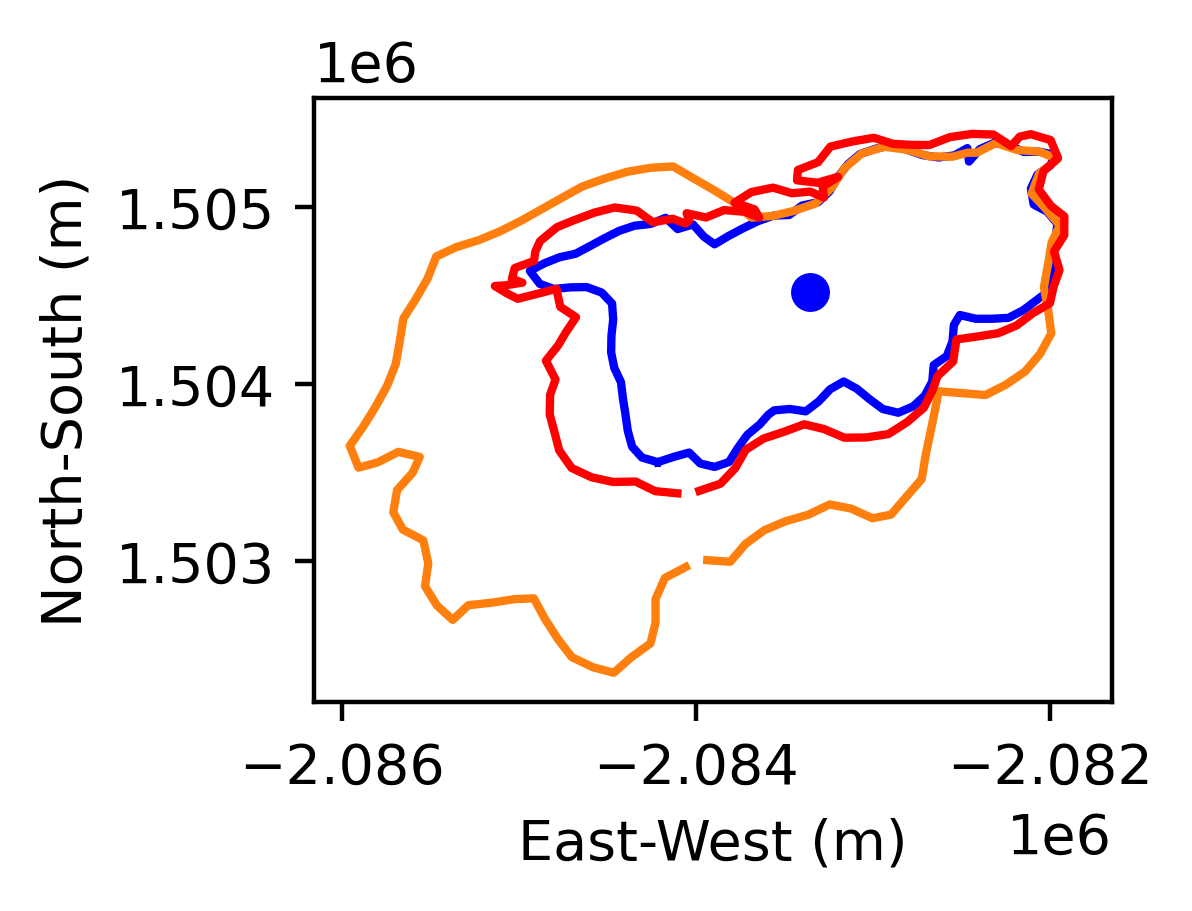

In [80]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=400)

plot_perimeter(ignition_aligned, ax=ax, color='blue')
# plot_perimeter(modified_vertices, ax=ax, ls='--')
plot_perimeter(observe_aligned, ax=ax, color='tab:orange')
# # plot_perimeter(next_observe_aligned, ax=ax, color='tab:red')
plot_perimeter(model_aligned, color='red', ax=ax)
ax.plot(np.mean(ignition_aligned, axis=0)[0], np.mean(ignition_aligned, axis=0)[1], 'o', color='blue')

ax.set_aspect(1)
    
xlim = (-2086157.8176353823, -2081650.1039221247)
ylim = (1502205.458511021, 1505619.1686423323)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('East-West (m)')
ax.set_ylabel('North-South (m)')